<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/seqeuence/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series / Sequences

* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
  * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

## Univariate Sequences

just one variable per time step

In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [2]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [3]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [4]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential, Model

# define model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features), name="LSTM_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

In [45]:
n_steps * n_features * 50 * 4

600

In [22]:
# fit model
%time history = model.fit(X, y, epochs=200, verbose=0)

CPU times: user 3.22 s, sys: 130 ms, total: 3.35 s
Wall time: 2.83 s


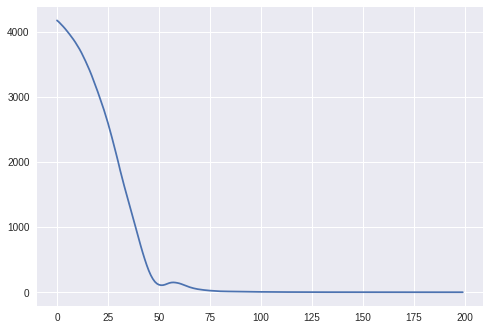

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [24]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]])
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10],
        [20],
        [30]],

       [[70],
        [80],
        [90]]])

In [31]:
y_pred = model.predict(X_sample)
y_pred

array([[140.99083],
       [273.49747],
       [364.1403 ]], dtype=float32)

In [0]:
def predict(model, samples, n_features=1):
  input = np.array(samples)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [34]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[140.99083],
       [273.49747],
       [364.1403 ]], dtype=float32)

### Multi Layer LSTM

In [40]:
# what comes out of an LSTM?
lstm_layer = model.get_layer("LSTM_Input")
model_stub = Model(inputs = model.input, outputs = lstm_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden

array([[ 8.492323 , 19.756756 ,  0.       , 11.27233  ,  0.       ,
         0.       ,  3.3596334,  0.       ,  0.       ,  0.       ,
         0.       ,  5.1300163,  0.       , 19.070362 ,  7.996299 ,
        17.051601 ,  7.4673023, 10.232378 ,  0.       ,  0.       ,
         9.2227955, 12.616403 ,  0.       ,  0.       ,  0.       ,
        14.955908 ,  0.       ,  0.       ,  0.       ,  0.       ,
        20.106274 ,  0.       ,  0.       ,  0.       ,  8.906113 ,
        13.373091 ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  9.900894 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ]],
      dtype=float32)

### What's the issue?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we can use

### We need to look into the LSTM a bit more deeply now

In [75]:
# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)

from tensorflow.keras.layers import GRU

rnn_units = 1

model = Sequential()
model.add(LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
# model.add(GRU(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_Input (LSTM)             (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [74]:
output_dimension = rnn_units
input_dimension = n_features
parameters = 4 * (output_dimension ** 2 +  output_dimension * input_dimension + output_dimension) 
parameters

12

In [81]:
# from only a single output for the final timestep
# ideal for feeding into something that *does not* handle timesteps
rnn_units = 1
model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features))
])
predict(model, [[10, 20, 30]])

array([[0.]], dtype=float32)

In [83]:
# to one output for each timestep
# ideal for feeding into something that *expects* timesteps
rnn_units = 1
model = Sequential([
    LSTM(units=rnn_units, activation='relu', input_shape=(n_steps, n_features), return_sequences=True)
])
predict(model, [[10, 20, 30]])

array([[[0.],
        [0.],
        [0.]]], dtype=float32)